# TODO
- Kalman filter & smoother including stimulus
- Kalman smoother output including cross-time covariances

In [76]:
# import python packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline
from scipy import interpolate
from scipy import signal
import pylab
from pykalman import KalmanFilter
import time
from sklearn.decomposition import FactorAnalysis
import pickle

In [77]:
# local own implementations
%load_ext autoreload
%autoreload 2
from PLDS_Macke2015 import PLDS, EM, print_par

def standard(x):
    return (x-np.nanmean(x))/np.sqrt(np.nanvar(x))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# simulate data
below I simulate from the PLDS model by creating a PLDS object

the latent is a linear dynamical system:
$$x_t=Ax_{t-1}+\epsilon$$
$$\epsilon\sim N(0, Q)$$
$$x_0\sim N(\mu_o, Q_0)$$

the observed is Poisson
$$y_t\sim Poisson\left(exp(Cx_t+Bs_t)\right)$$
where B is the stimulus coefficient and s is the stimulus at time point t

## simulate LDS latent and PLDS data

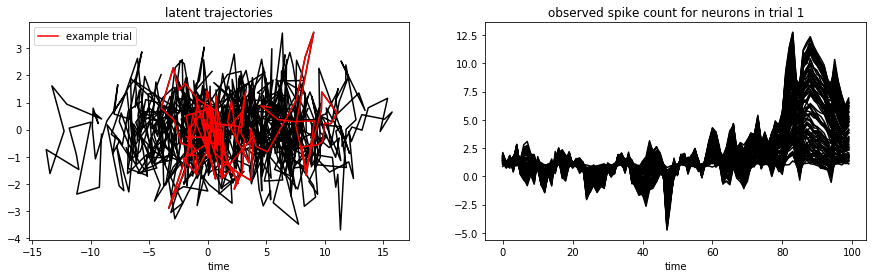

In [78]:
# noise type (if False, simulate a regular Kalman LDS with Gaussian noise)
poisson = False 
#### parameters used ####
seed = 1
np.random.seed(seed)
# number of time points in a trial
n_step = np.array([100])
# number of trials
Ttrials = 10
# latent dimension
xdim = 2
# time constant of latent
A = [0.99,.4]*np.eye(xdim) 
# latent noise parameters
sigQ = 1 
Q = np.eye(xdim)*sigQ  
Q0 = np.eye(xdim)*sigQ
x0 = np.zeros([xdim])+np.random.randn(2)*.1 # this is mu_0, sorry
# observed dimension (number of neurons)
ydim = 100
# loadings, mapping function from latent to observed
cscal = 1
C = cscal*np.random.rand(ydim*xdim).reshape(ydim, xdim)
# if observed is Gaussian and not Poisson (so if poisson=False above) we have the Gaussian noise term here:
R = np.eye(ydim)*.01
# stimulus dimension
sdim = 1
# stimulus coefficient
B = cscal*np.ones([ydim,sdim])#*np.random.randn(ydim, sdim)
# stimulus (if stimulus dimension is 1, there is only an offset firing rate)
S = np.ones([n_step[0], sdim, Ttrials])
if sdim>1:
    S[:,0,:] = np.round(np.random.rand(n_step[0]*Ttrials)).reshape(n_step[0],Ttrials)
S = np.array(S, dtype='int')
# create model
MOD = PLDS(xdim=xdim, ydim=ydim, n_step=n_step, C=C, Q0=Q0, A=A, Q=Q, x0=x0,R=R,
        Ttrials=Ttrials, B=B)
# sample from model
MOD.sample(poisson=poisson, X=S)
# visualize
MOD.vis_xy()
# get data (observed neuron activity)
data = MOD.y.copy() # code expects data to be T by ydim by Trials

# Demo

## full EM fitting
fit a PLDS model (latent and model parameters) given the sampled data

In [79]:
data = MOD.y.copy()

In [80]:
#data = np.load('/Users/carolinehaimerl/Downloads/'+'data.npy')
#S = None

In [81]:
data.shape

(100, 100, 10)

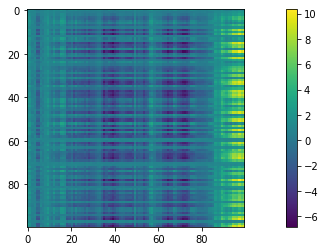

In [82]:
plt.figure(figsize=(15,4))
plt.imshow(data[:,:,2].T);
plt.colorbar()

In [83]:
fit = EM(maxiter=10, gtol=np.sqrt(np.sum(MOD.C**2))*.001)
# define maximum number of iterations and when to stop looking for better solutions 
# (ltol is amount of likelihood increase)
maxiterem=5
ltol=-1000 #1e-3
# estimate the model parameters via the EM algorithm
# output is a PLDS class object with the fitted parameters
# and Var_latent which is a list with #trials entries
# each has itself #time points entries
# that gives the latent covariance matrix for each time point
# and tells you something about how much uncertainty there is about the latent
MOD_fit, Var_latent = fit.fit(data=data, xdim=2, poisson=poisson, 
               seed=2, S=S, maxiterem=maxiterem, ltol=ltol,
              cscal=cscal, sigQ = sigQ , a=.1, sigR=.1, upx0=False,
                             analytic=True) # the last 4 parameters help initialize the model

--- iter 1 ---
    E-step
100
[[ 0.09284939 -0.00101302]
 [-0.00101302  0.82664415]]
   lower bound at start  2081078.7052477691
    M-step


IndexError: list index out of range

In [73]:
mu, sigma = MOD.E_step(MOD.x, data, MOD.B, MOD.C, MOD.A, MOD.Q, MOD.Q0, MOD.x0, MOD.R, X=S, 
           poisson=False, analytic=True)

100
[[ 0.07231681 -0.04890668]
 [-0.04890668  0.06039834]]


In [74]:
sigma[0][data.shape[0]-1]

[array([[ 0.07231681, -0.04890668],
        [-0.04890668,  0.06039834]])]

In [9]:
from PLDS_Macke2015 import unroll

[0.35148474 0.10007631]


Text(0, 0.5, 'second fitted latent dimension')

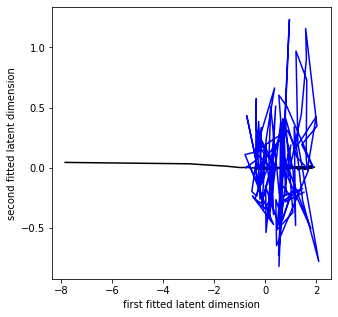

In [10]:
if MOD_fit.xdim == 2:
    print(np.linalg.svd(MOD_fit.A)[1])
    # visualize the 2-dim latent of an example trial
    ttrial = 0
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    ax.plot(MOD_fit.x[:,0,ttrial], MOD_fit.x[:,1,ttrial], '-k')
    #ax.plot(MOD.x[:,0,ttrial], MOD.x[:,1,ttrial], '--k')
    fa = FactorAnalysis(n_components=MOD_fit.xdim).fit(unroll(data))
    ax.plot(fa.transform(data[:,:,ttrial])[:,0], fa.transform(data[:,:,ttrial])[:,1], '-b')
    if Var_latent is not None:
        for tt in range(MOD_fit.x.shape[0]):
            evals = np.linalg.eigvals(Var_latent[ttrial][tt][0])
            e = Ellipse((MOD_fit.x[tt,0,ttrial], MOD_fit.x[tt,1,ttrial]), 
                   width = 2*np.sqrt(evals[0]), height= 2*np.sqrt(evals[1]),
                    angle=np.arctan2(evals[0]-Var_latent[ttrial][tt][0][0,0], Var_latent[ttrial][tt][0][0,1]))
            ax.add_artist(e)
            e.set_alpha(.4)
            e.set_facecolor('k')
    
ax.set_xlabel('first fitted latent dimension')
ax.set_ylabel('second fitted latent dimension')


[0.35148474 0.10007631]


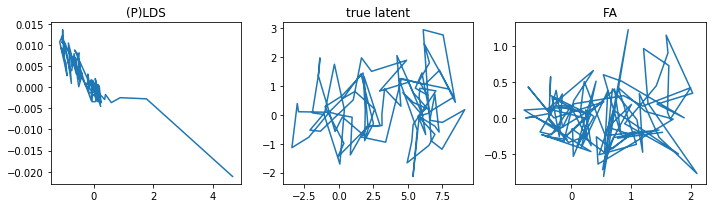

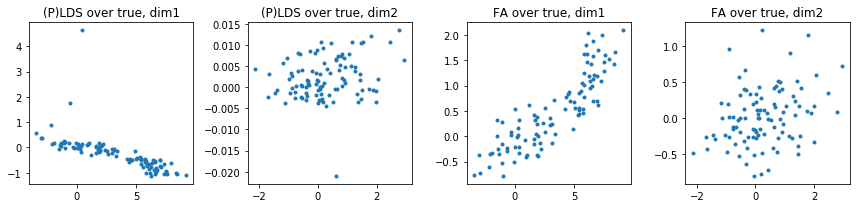

In [11]:
ttrial = 0
U, s, VT = np.linalg.svd(MOD_fit.A)
print(s)
fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].plot((np.diag(np.sqrt(s)).dot(VT.dot(MOD_fit.x[:,:,ttrial].T)))[0,:], 
     (np.diag(np.sqrt(s)).dot(VT.dot(MOD_fit.x[:,:,ttrial].T)))[1,:])
ax[1].plot(MOD.x[:,0,ttrial], MOD.x[:,1,ttrial])
fa = FactorAnalysis(n_components=MOD_fit.xdim).fit(unroll(data))
ax[2].plot(fa.transform(data[:,:,ttrial])[:,0], fa.transform(data[:,:,ttrial])[:,1])
ax[0].set_title('(P)LDS')
ax[1].set_title("true latent")
ax[2].set_title("FA")
fig.tight_layout()

fig, ax = plt.subplots(1,4, figsize=(12,3))
ax[0].plot(MOD.x[:,0,ttrial], (np.diag(np.sqrt(s)).dot(VT.dot(MOD_fit.x[:,:,ttrial].T)))[0,:], '.')
ax[1].plot(MOD.x[:,1,ttrial], (np.diag(np.sqrt(s)).dot(VT.dot(MOD_fit.x[:,:,ttrial].T)))[1,:], '.')
ax[2].plot(MOD.x[:,0,ttrial], fa.transform(data[:,:,ttrial])[:,0], '.')
ax[3].plot(MOD.x[:,1,ttrial], fa.transform(data[:,:,ttrial])[:,1], '.')
ax[0].set_title('(P)LDS over true, dim1')
ax[1].set_title('(P)LDS over true, dim2')
ax[2].set_title('FA over true, dim1')
ax[3].set_title('FA over true, dim2')
fig.tight_layout()

## cross-validation
via the reconstruction error

leave-neuron-out approach

can be used to assess the dimensionality of the model

In [43]:
# create testing data:

# stimulus during testing data
S_test = np.ones([n_step[0], sdim, Ttrials])
if sdim>1:
    S_test[:,0,:] = np.round(np.random.rand(n_step[0]*Ttrials)).reshape(n_step[0],Ttrials)
S_test = np.array(S_test, dtype='int')

# create testing data
MOD.sample(poisson=poisson, X=S_test, seed=10)
data_test = MOD.y.copy()

In [44]:
# given a fitted model MOD_fit and test data (+stimuli at test time)
# computing the reconstruction error can take some time, therefore there is an option of just computing it for
# some neurons (if neurons=None, it will be computed for all neurons)
neurons = np.array([10, 30, 50])
pred, mse, mu = fit.reconstruction(data_test, S_test, MOD_fit, poisson=poisson, neurons=neurons)
# output: pred is the prediction for each neuron from the model, if a neuron was not used there will be NaNs, 
# the shape is always time points by neurons by trials,
# mse is the averaged square prediction error over time points and trials, a vector of #neurons entries

prediction for neuron 10
   compute mu through inference
   compute sigma
-------  9.643 sec -------
prediction for neuron 30
   compute mu through inference
   compute sigma
-------  9.348 sec -------
prediction for neuron 50
   compute mu through inference
   compute sigma
-------  9.602 sec -------


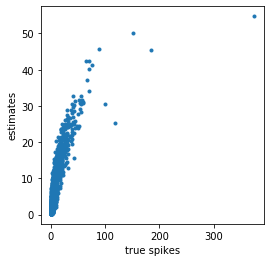

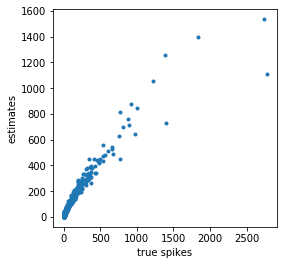

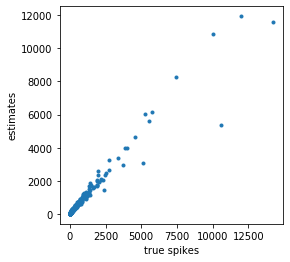

In [56]:

for nn in neurons:
    plt.figure(figsize=(4,4))
    plt.plot(data_test[:,nn,:].ravel(), pred[:,nn,:].ravel(), '.')
    plt.xlabel('true spikes')
    plt.ylabel('estimates')

# Details: inference and learning
below are stepwise tests of the different functions and implementation details

## inference

In [ ]:
ttrial=0
print('test for likelihood function P(y|x)')
MOD.test_log_lik(MOD.x[:MOD.n_step[ttrial],:,ttrial], 
                MOD.B, MOD.C, Rtmp=MOD.R, poisson=poisson, X=S[:MOD.n_step[ttrial],:,ttrial])
MOD.test_J_log_lik(MOD.x[:MOD.n_step[ttrial],:,ttrial],
                MOD.B, MOD.C, Rtmp=MOD.R, poisson=poisson, X=S[:MOD.n_step[ttrial],:,ttrial])
MOD.test_H_log_lik(MOD.x[:MOD.n_step[ttrial],:,ttrial], 
                MOD.B, MOD.C, Rtmp=MOD.R, poisson=poisson, X=S[:MOD.n_step[ttrial],:,ttrial])
print(' ')
print('test for prior function Px)')
MOD.test_log_prior(MOD.x[:MOD.n_step[ttrial],:,ttrial], MOD.A, 
                     MOD.Q, MOD.Q0, MOD.x0)
MOD.test_J_log_prior(MOD.x[:MOD.n_step[ttrial],:,ttrial], MOD.A, 
                     MOD.Q, MOD.Q0, MOD.x0)
MOD.test_H_log_prior(MOD.x[:MOD.n_step[ttrial],:,ttrial], MOD.A, 
                     MOD.Q, MOD.Q0)
print(' ')
print('test for block-list conversion')
MOD.test_block(np.round(MOD.H_log_posterior(MOD.x[:MOD.n_step[ttrial],:,ttrial], MOD.y[:MOD.n_step[ttrial],:,ttrial], MOD.B, MOD.C, MOD.A, MOD.Q, 
              MOD.Q0, MOD.x0, MOD.R, poisson=poisson, X=S[:MOD.n_step[ttrial],:,ttrial])), mdim=[MOD.xdim, MOD.xdim], offdiag=1)

In [ ]:
from scipy.optimize import minimize

In [ ]:
Xtmp0 = np.sqrt(np.nanvar(MOD.x))*np.random.randn(MOD.x.shape[0], MOD.x.shape[1], MOD.x.shape[2])

Xres = MOD.inference(Xtmp0, MOD.y, MOD.B, MOD.C, MOD.A, MOD.Q, 
              MOD.Q0, MOD.x0, MOD.R, X=S, poisson=poisson, 
              disp=False)



In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
for ff in range(MOD.xdim):
    ax[ff].plot(MOD.x[:,ff,:].ravel(), '-k', label='true')
    ax[ff].plot(Xtmp0[:,ff,:].ravel(), '--', color='grey', label='initialization')
    ax[ff].plot(Xres[:,ff,:].ravel(), '-r', label='impl')
    ax[ff].set_xlabel('time')
    ax[ff].set_ylabel('x')
ax[ff].legend()
fig.tight_layout()
fig, ax = plt.subplots(1,2,figsize=(10,4))
for ff in range(MOD.xdim):
    ax[ff].plot(standard(MOD.x[:,ff,:].ravel()),
               standard(MOD.x[:,ff,:].ravel()), '-k')
    ax[ff].plot(standard(MOD.x[:,ff,:].ravel()),
                standard(Xtmp0[:,ff,:].ravel()),'.', color='grey')
    ax[ff].plot(standard(MOD.x[:,ff,:].ravel()), 
                standard(Xres[:,ff,:].ravel()),'r.')
    ax[ff].set_xlabel('standardized true x')
    ax[ff].set_ylabel('standardized estimated x')
fig.tight_layout()

In [ ]:
if poisson: 
    R = np.eye(MOD.ydim)*np.sqrt(np.nanvar(MOD.y))
    y = MOD.y.copy()
    y[y<=0] = 1e-10
    y = np.log(y)
else: 
    R = MOD.R.copy()
    y = MOD.y.copy()
Xkal = np.zeros(MOD.x.shape)*np.nan
for ttrial in range(MOD.Ttrials):
    kf = KalmanFilter(n_dim_state=MOD.xdim, n_dim_obs=MOD.ydim,
                     transition_matrices=MOD.A,
                     transition_covariance=MOD.Q,
                     observation_matrices=MOD.C,
                     observation_covariance=R, 
                     initial_state_mean=MOD.x0,
                     initial_state_covariance=MOD.Q0)
    # Kalman filtering
    filtered_state_means, filtered_state_covariances = kf.filter(y[:,:,ttrial])
    # Kalman smoothing
    smoothed_state_means, smoothed_state_covariances = kf.smooth(y[:,:,ttrial])
    Xkal[:,:,ttrial] = smoothed_state_means

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
for ff in range(MOD.xdim):
    ax[ff].plot(MOD.x[:,ff,:].ravel(), '-k')
    ax[ff].plot(Xtmp0[:,ff,:].ravel(), '--', color='grey', label='initialization')
    ax[ff].plot(Xres[:,ff,:].ravel(), '-r', label='impl')
    ax[ff].plot(Xkal[:,ff,:].ravel(), '-g', label='kf')
    ax[ff].set_xlabel('time')
    ax[ff].set_ylabel('x')
ax[ff].legend()
fig.tight_layout()
fig, ax = plt.subplots(1,2,figsize=(10,4))
for ff in range(MOD.xdim):
    ax[ff].plot(standard(MOD.x[:,ff,:].ravel()),
               standard(MOD.x[:,ff,:].ravel()), '-k')
    ax[ff].plot(standard(MOD.x[:,ff,:].ravel()),
                standard(Xtmp0[:,ff,:].ravel()),'.', color='grey')
    ax[ff].plot(standard(MOD.x[:,ff,:].ravel()), 
                standard(Xres[:,ff,:].ravel()),'r.')
    ax[ff].plot(standard(MOD.x[:,ff,:].ravel()), 
                standard(Xkal[:,ff,:].ravel()),'g.')
    ax[ff].set_xlabel('standardized true x')
    ax[ff].set_ylabel('standardized estimated x')
fig.tight_layout()

### if y was noiseless (= rate)

In [ ]:
ytmp = np.zeros(MOD.y.shape)
for kk in range(MOD.Ttrials):
    if poisson:
        ytmp[:,:,kk] = np.exp(MOD.C.dot(MOD.x[:,:,kk].T)+MOD.B.dot(S[:,:,kk].T)).T
    else:
        ytmp[:,:,kk] = (MOD.C.dot(MOD.x[:,:,kk].T)+MOD.B.dot(S[:,:,kk].T)).T


X0 = np.sqrt(np.nanvar(MOD.x))*np.random.randn(MOD.x.shape[0], MOD.x.shape[1], MOD.x.shape[2])

mu = MOD.inference(X0, ytmp, MOD.B, MOD.C, MOD.A, MOD.Q, 
              MOD.Q0, MOD.x0, MOD.R, X=S, poisson=poisson, 
              disp=False)

#mu, sigma = MOD.E_step(MOD.x,ytmp, MOD.B, MOD.C, MOD.A, MOD.Q, 
#                      MOD.Q0, MOD.x0, MOD.R, X=S,
#                       poisson=poisson, disp=False)
fig, ax = plt.subplots(1,3,figsize=(10,3))
ax[0].plot(MOD.x[:,0,:].ravel(),MOD.x[:,1,:].ravel(), 'ok')
ax[0].plot(mu[:,0,:].ravel(),mu[:,1,:].ravel(), 'b')
ax[0].set_xlabel('x dim 1')
ax[0].set_xlabel('x dim 2')
ax[1].plot(MOD.x[:,0,:].ravel(), mu[:,0,:].ravel(), '.')  
ax[2].plot(MOD.x[:,1,:].ravel(), mu[:,1,:].ravel(), '.')  
for aa in range(2):
    ax[aa].set_xlabel('true x')
    ax[aa].set_ylabel('fitted x')
fig.tight_layout()

fig, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].plot(mu[:,0,:].ravel(), 'b')
ax[0].plot(MOD.x[:,0,:].ravel(), 'k')
ax[1].plot(mu[:,1,:].ravel(), 'b')
ax[1].plot(MOD.x[:,1,:].ravel(), 'k')
for aa in range(2):
    ax[aa].set_xlabel('time')
    ax[aa].set_ylabel('x')
fig.tight_layout()

## learning

### parameters of latent space

In [ ]:
# noiseless (xtmp, ytmp) versus with noise MOD.y
mu, sigma = MOD.E_step(MOD.x,MOD.y, MOD.B, MOD.C, MOD.A, MOD.Q, 
                      MOD.Q0, MOD.x0, MOD.R, X=S,
                       poisson=poisson, disp=False)
if poisson: 
    R = np.eye(MOD.ydim)*np.sqrt(np.nanvar(MOD.y))
    y = MOD.y.copy()
    y[y<=0] = 1e-10
    y = np.log(y)
else: 
    R = MOD.R.copy()
    y = MOD.y.copy()

In [ ]:
kf = KalmanFilter(n_dim_state=MOD.xdim, n_dim_obs=MOD.ydim,
                 transition_matrices=MOD.A,
                 transition_covariance=MOD.Q,
                 observation_matrices=MOD.C,
                 observation_covariance=R, 
                 #initial_state_mean=MOD.x0,
                 initial_state_covariance=MOD.Q0
                 )
kf.em(y[:,:,0], n_iter=20)
print('x0 estimated via Kalman: \n', kf.initial_state_mean)
print('x0 estimated via PLDS-impl: \n', np.round(MOD.upx0(mu),4))
print('true x0: \n', MOD.x0)

In [ ]:
kf = KalmanFilter(n_dim_state=MOD.xdim, n_dim_obs=MOD.ydim,
                 transition_matrices=MOD.A,
                 transition_covariance=MOD.Q,
                 observation_matrices=MOD.C,
                 observation_covariance=R, 
                 initial_state_mean=MOD.x0,
                 #initial_state_covariance=MOD.Q0
                 )
kf.em(y[:,:,0], n_iter=20)
print('Q0 estimated via Kalman: \n', kf.initial_state_covariance)
print('Q0 estimated via PLDS-impl: \n', np.round(MOD.upQ0(MOD.x0, mu, [sigma[kk][0][0] for kk in range(MOD.Ttrials)]),4))
print('true Q0: \n', MOD.Q0)

In [ ]:
if poisson: R = np.eye(MOD.ydim)*np.sqrt(np.nanvar(MOD.y))
else: R = MOD.R.copy()
kf = KalmanFilter(n_dim_state=MOD.xdim, n_dim_obs=MOD.ydim,
                 transition_matrices=MOD.A,
                 #transition_covariance=MOD.Q,
                 observation_matrices=MOD.C,
                 observation_covariance=R, 
                 initial_state_mean=MOD.x0,
                 initial_state_covariance=MOD.Q0)
kf.em(y[:,:,0], n_iter=20)
print('Q estimated via Kalman: \n', kf.transition_covariance)
print('Q estimated via PLDS-impl: \n', np.round(MOD.upQ(MOD.A, mu, sigma),6))
print('true Q: \n', MOD.Q)

In [ ]:
if poisson: R = np.eye(MOD.ydim)*np.sqrt(np.nanvar(MOD.y))
else: R = MOD.R.copy()
kf = KalmanFilter(n_dim_state=MOD.xdim, n_dim_obs=MOD.ydim,
                 #transition_matrices=MOD.A,
                 transition_covariance=MOD.Q,
                 observation_matrices=MOD.C,
                 observation_covariance=R, 
                 initial_state_mean=MOD.x0,
                 initial_state_covariance=MOD.Q0)
kf.em(y[:,:,0], n_iter=20)
print('A estimated via Kalman: \n', kf.transition_matrices)
print('A estimated via PLDS-impl: \n', np.round(MOD.upA(mu, sigma),3))
print('true A: \n', MOD.A)

### parameters of observation space


In [ ]:
# noiseless (xtmp, ytmp) versus with noise
mu, sigma = MOD.E_step(MOD.x,MOD.y, MOD.B, MOD.C, MOD.A, MOD.Q, 
                      MOD.Q0, MOD.x0, MOD.R, X=S,
                       poisson=poisson, disp=False)

In [ ]:
print('L(x) for true x: ', -MOD.L_dyn(MOD.x, mu, sigma, MOD.x0, MOD.Q0))
print('L(x) for random x: ', -MOD.L_dyn(np.random.randn(MOD.x.shape[0], MOD.x.shape[1], MOD.x.shape[2]),
          mu, sigma, MOD.x0, MOD.Q0))

In [ ]:
B0 = np.random.randn(MOD.B.shape[0], MOD.B.shape[1])
Best = MOD.upB(B0, MOD.C, MOD.y, mu, sigma, X=S, Rtmp=MOD.R,
             disp=True, gtol=1e-02, maxiter=10, poisson=poisson)
fig, ax = plt.subplots(1,np.max([2,MOD.B.shape[1]]),figsize=(8,3))
for bb in range(MOD.B.shape[1]):
    ax[bb].plot(MOD.B[:,bb], MOD.B[:,bb], '-k')
    ax[bb].plot(MOD.B[:,bb], B0[:,bb], '.', color='grey')
    ax[bb].plot(MOD.B[:,bb], Best[:,bb], '.r')
    ax[bb].set_title('stimulus dimension '+np.str(bb))

In [ ]:
if poisson==False:
    print('Warning: numerical approx of C with Gaussian noise not yet working')
C0 = np.random.randn(MOD.ydim, MOD.xdim)
Cest = MOD.upC(C0, MOD.B, MOD.y, mu, sigma, X=S, Rtmp=MOD.R,
        disp=False, gtol=1e-5, maxiter=50, poisson=poisson)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
for xx in range(2):
    ax[xx].plot(MOD.C[:,xx], C0[:,xx], '.', color='grey', label='$C_{start}$')
    ax[xx].plot(MOD.C[:,xx], Cest[:,xx], '.r', label='$C_{final}$')
    ax[xx].set_title('C for latent dimension '+np.str(bb+1))
    ax[xx].set_xlabel('true C')
    ax[xx].set_ylabel('estimated C')
ax[0].legend()
fig.tight_layout()

### test: gradient of neg lower bound given noiseless data

In [ ]:
ytmp = np.zeros(MOD.y.shape)
for kk in range(MOD.Ttrials):
    if poisson:
        ytmp[:,:,kk] = np.exp(MOD.C.dot(MOD.x[:,:,kk].T)+MOD.B.dot(S[:,:,kk].T)).T
    else:
        ytmp[:,:,kk] = (MOD.C.dot(MOD.x[:,:,kk].T)+MOD.B.dot(S[:,:,kk].T)).T
mu, sigma = MOD.E_step(MOD.x,MOD.y, MOD.B, MOD.C, MOD.A, MOD.Q, 
                      MOD.Q0, MOD.x0, MOD.R, X=S,
                       poisson=poisson, disp=False)
print('using noiseless y:\n')
print('neg lower bound given random C: ', MOD.L_obs(C0, MOD.B, ytmp, mu, sigma, X=S,Rtmp=MOD.R, poisson=poisson))
print('neg lower bound given true C: ',MOD.L_obs(MOD.C, MOD.B, ytmp, mu, sigma, X=S,Rtmp=MOD.R, poisson=poisson))
fig, ax = plt.subplots(1,2,figsize=(8,3))
for xx in range(2):
    ax[xx].plot(MOD.J_L_obs_C(C0, MOD.B, ytmp, mu, sigma, X=S,Rtmp=MOD.R, poisson=poisson)[:,xx], 'r', label='grad $C_{start}$')
    ax[xx].plot(MOD.J_L_obs_C(MOD.C, MOD.B, ytmp, mu, sigma, X=S,Rtmp=MOD.R, poisson=poisson)[:,xx],'b', label='grad $C_{true}$')
    ax[xx].set_title('deriv_C: gradient for dimension '+np.str(xx+1))
    ax[xx].set_xlabel('neurons')
    ax[xx].set_ylabel('gradient')
ax[0].legend()
fig.tight_layout()

In [ ]:
ytmp = np.zeros(MOD.y.shape)
for kk in range(MOD.Ttrials):
    if poisson:
        ytmp[:,:,kk] = np.exp(MOD.C.dot(MOD.x[:,:,kk].T)+MOD.B.dot(S[:,:,kk].T)).T
    else:
        ytmp[:,:,kk] = (MOD.C.dot(MOD.x[:,:,kk].T)+MOD.B.dot(S[:,:,kk].T)).T
mu, sigma = MOD.E_step(MOD.x,MOD.y, MOD.B, MOD.C, MOD.A, MOD.Q, 
                      MOD.Q0, MOD.x0, MOD.R, X=S,
                       poisson=poisson, disp=False)
print('using noiseless y:\n')
print('neg lower bound given random B: ', MOD.L_obs(MOD.C, B0, ytmp, mu, sigma, X=S, Rtmp=MOD.R, poisson=poisson))
print('neg lower bound given true B: ',MOD.L_obs(MOD.C, MOD.B, ytmp, mu, sigma, X=S, Rtmp=MOD.R, poisson=poisson))
fig, ax = plt.subplots(1,2,figsize=(8,3))
for xx in range(S.shape[1]):
    ax[xx].plot(MOD.J_L_obs_B(MOD.C, B0, ytmp, mu, sigma, X=S, Rtmp=MOD.R, poisson=poisson)[:,xx], 'r', label='grad $B_{start}$')
    ax[xx].plot(MOD.J_L_obs_B(MOD.C, MOD.B, ytmp, mu, sigma, X=S, Rtmp=MOD.R, poisson=poisson)[:,xx],'b', label='grad $B_{true}$')
    ax[xx].set_title('deriv_B: gradient for dimension '+np.str(xx+1))
    ax[xx].set_xlabel('neurons')
    ax[xx].set_ylabel('gradient')
ax[0].legend()
fig.tight_layout()

todo
- implement gaussian observation noise analytic and numeric update of C
- use Hessian for C and B optimization?

open questions
- update of B: possible analytically or only via likelihood maximization
- Q and Q0 always sytematically too small, why?

note
- had to tweak the optimization method in scipy minimize, to compute the latent posterior (E-step inference) Newton threw back error for the reconstruction